---

title: "Analysis of Banfield Tree of life"

author: Benjamin Doran

date: today

---

## Setup

In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using SPI, StatsBase
using FASTX, CSV, DataFrames
using NewickTree, NewickTreeTools
using StatsPlots

include(srcdir("helpers.jl"))
include(srcdir("neighborjoining.jl"))
using Main.NeighborJoining: fastNJ, newickstring

# using BioServices.EUtils, EzXML

In [2]:
rdir = datadir("exp_pro", "banfield_etal_data")
pdir = plotsdir("banfieldtree_analysis_mark2") |> mkpath
mdir = joinpath(rdir, "jbMIscores") |> mkpath
sdir = joinpath(rdir, "subset_data") |> mkpath
jbdir = joinpath(rdir, "justbacteria_data") |> mkpath

"/Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data"

In [3]:
banfieldtree = readnw(open(readline, joinpath(sdir, "subset_banfieldtree.nw")))
adf = CSV.read(joinpath(sdir, "subset_alignment.csv"), DataFrame)
lineagedf = CSV.read(joinpath(sdir, "subset_lineage.csv"), DataFrame);

In [4]:
fullbanfieldtree = readnw(open(readline, joinpath(rdir, "treeoflife_processed.nw")));

In [5]:
lineagedf = lineagedf |> df -> coalesce.(df, "") |>
    df -> filter(:kingdom => ==("Bacteria"), df) |>
    unique;

In [6]:
filteredbanfieldtree = NewickTree.extract(fullbanfieldtree, lineagedf.ORGANISM);

In [7]:
justbacteria_adf = adf[indexin(lineagedf.ORGANISM, adf.label), :];

In [8]:
# write out 
open(joinpath(jbdir, "subset_banfieldtree.nw"), "w") do io
    println(io, NewickTree.nwstr(filteredbanfieldtree))
end
CSV.write(joinpath(jbdir, "subset_lineage.csv"), lineagedf);
CSV.write(joinpath(jbdir, "subset_alignment.csv"), justbacteria_adf);

## read in subset data

In [9]:
banfieldtree = readnw(open(readline, joinpath(jbdir, "subset_banfieldtree.nw")))
adf = CSV.read(joinpath(jbdir, "subset_alignment.csv"), DataFrame)
lineagedf = CSV.read(joinpath(jbdir, "subset_lineage.csv"), DataFrame);

In [10]:
length(getleafnames(banfieldtree))

2117

### Make SPI trees

In [11]:
### Make SPI trees from alignment ###

binarymtx = onehotencode(adf.sequence)
usv = svd(Matrix(binarymtx));
partitions = getintervals(usv.S, alpha=1.5, q=0.75)
spiDij = calc_spi_mtx(usv.U, usv.S, partitions) / length(adf.sequence[1]);


In [13]:
length(partitions)

314

In [ ]:

# hc = hclust(spiDij, linkage=:single, branchorder=:optimal)
# spi_single_nwstring = SPI.nwstr(hc, adf.sample_id; labelinternalnodes=false)
# open(joinpath(sdir, "spitree.single.nw"), "w") do io
#     println(io, spi_single_nwstring)
# end

# hc = hclust(spiDij, linkage=:complete, branchorder=:optimal)
# spi_complete_nwstring = SPI.nwstr(hc, adf.sample_id; labelinternalnodes=false)
# open(joinpath(sdir, "spitree.complete.nw"), "w") do io
#     println(io, spi_complete_nwstring)
# end

hc = hclust(spiDij, linkage=:average, branchorder=:optimal)
spi_upgma_nwstring = SPI.nwstr(hc, adf.sample_id; labelinternalnodes=false)
open(joinpath(jbdir, "spitree.upgma.nw"), "w") do io
    println(io, spi_upgma_nwstring)
end

njclust = fastNJ(spiDij);
spi_nj_nwstring = newickstring(njclust, adf.sample_id)
open(joinpath(jbdir, "spitree.neighborjoined.nw"), "w") do io
    println(io, spi_nj_nwstring)
end

# CSV.write(joinpath(rdir, "alignment_tipmeta.csv"), adf[:, ["tip_ids", "label"]])
# tip_ids = ["Tip_$i" for i in 1:nrow(adf)];
# writephylip(joinpath(rdir, "spidist.phylip"), spiDij, tip_ids)

In [12]:
charmtx = SPI._stringcolumntocharmtx(adf.sequence);

In [13]:
Nboot = 100
Nchars = length(adf.sequence[1])

spi_upgma_nw_bootstrings = []
spi_nj_nw_bootstrings = []
@time begin
for i in 1:Nboot
    cols = sample(axes(charmtx,2), size(charmtx, 2), replace=true)
    binarymtx = onehotencode(charmtx[:, cols])
    usv = svd(Matrix(binarymtx));
    spiDij = calc_spi_mtx(usv.U, usv.S, getintervals(usv.S)) / Nchars;

    upgma_hc = hclust(spiDij, linkage=:single, branchorder=:optimal)
    push!(spi_upgma_nw_bootstrings, SPI.nwstr(upgma_hc, adf.sample_id; labelinternalnodes=false))

    njclust = fastNJ(spiDij);
    spi_nj_boot_nwstring = newickstring(njclust, adf.sample_id)
    push!(spi_nj_nw_bootstrings, spi_nj_boot_nwstring)
end

open(joinpath(jbdir, "spitree.upgma.boottrees.nw"), "w") do io
    for btree in spi_upgma_nw_bootstrings
        println(io, btree)
    end
end

open(joinpath(jbdir, "spitree.neighborjoined.boottrees.nw"), "w") do io
    for btree in spi_nj_nw_bootstrings
        println(io, btree)
    end
end
end

4682.392722 seconds (23.30 M allocations: 2.144 TiB, 4.45% gc time, 0.01% compilation time)


In [14]:
using Gotree_jll

In [15]:
reftreefile = joinpath(jbdir, "spitree.upgma.nw")
boottreesfile = joinpath(jbdir, "spitree.upgma.boottrees.nw")
outfile = joinpath(jbdir, "spitree.upgma.supporttree.nw")
run(`$(gotree()) compute support booster -i $reftreefile -b $boottreesfile -o $outfile`)

BOOSTER Support
Date        : 15 Apr 23 20:17 CDT
Input tree  : /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.upgma.nw
Boot trees  : /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.upgma.boottrees.nw
Output tree : /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.upgma.supporttree.nw
CPUs        : 1
2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:1

2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:25 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:26 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:26 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:26 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:26 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:26 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:26 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:26 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:26 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:26 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:26 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:27 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:27 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:27 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:27 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:27 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:27 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:27 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:27 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:27 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:27 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:28 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:28 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:28 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:28 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:28 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:28 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:28 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:28 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:28 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:28 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:29 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:30 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:30 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:30 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:30 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:30 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:30 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:30 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:30 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:30 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:30 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:31 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:32 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:33 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:33 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:33 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:33 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:33 Newick : Branch lengths attached to root node are ignored


End         : 15 Apr 23 20:17 CDT


Process(setenv(`/Users/ben/.julia/artifacts/c369ee0388608fd926c86154ff68651cb9120d3d/bin/gotree compute support booster -i /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.upgma.nw -b /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.upgma.boottrees.nw -o /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.upgma.supporttree.nw`,["PATH=/Users/ben/.julia/artifacts/c369ee0388608fd926c86154ff68651cb9120d3d/bin:/Users/ben/.julia/juliaup/bin:/Users/ben/.local/bin:/usr/local/sbin:/Users/ben/opt/anaconda3/envs/ben/bin:/Users/ben/opt/anaconda3/condabin:/Users/ben/.google-sdk/google-cloud-sdk/bin:/opt/local/bin:/opt/local/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/opt/X11/bin:/Library/Apple/usr/bin:/Users/ben/Applications/quarto/bin:/Users/ben/.cargo/bin", "VSCODE_NLS_CONFIG={\"locale\":\"en-us\",\"osLocale\":

In [16]:
reftreefile = joinpath(jbdir, "spitree.neighborjoined.nw")
boottreesfile = joinpath(jbdir, "spitree.neighborjoined.boottrees.nw")
outfile = joinpath(jbdir, "spitree.neighborjoined.supporttree.nw")
run(`$(gotree()) compute support booster -i $reftreefile -b $boottreesfile -o $outfile`)

BOOSTER Support
Date        : 15 Apr 23 20:17 CDT
Input tree  : /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.neighborjoined.nw
Boot trees  : /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.neighborjoined.boottrees.nw
Output tree : /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.neighborjoined.supporttree.nw
CPUs        : 1
2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:45 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:46 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:47 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:48 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:49 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:50 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:51 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:51 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:51 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:51 Newick : Branch lengths attached to root node are ignored
2023/04/15 20:17:51 Newick : Branch lengths attached to root node are ignored


2023/04/15 20:17:51 Newick : Branch lengths attached to root node are ignored


End         : 15 Apr 23 20:17 CDT


Process(setenv(`/Users/ben/.julia/artifacts/c369ee0388608fd926c86154ff68651cb9120d3d/bin/gotree compute support booster -i /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.neighborjoined.nw -b /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.neighborjoined.boottrees.nw -o /Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/justbacteria_data/spitree.neighborjoined.supporttree.nw`,["PATH=/Users/ben/.julia/artifacts/c369ee0388608fd926c86154ff68651cb9120d3d/bin:/Users/ben/.julia/juliaup/bin:/Users/ben/.local/bin:/usr/local/sbin:/Users/ben/opt/anaconda3/envs/ben/bin:/Users/ben/opt/anaconda3/condabin:/Users/ben/.google-sdk/google-cloud-sdk/bin:/opt/local/bin:/opt/local/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/opt/X11/bin:/Library/Apple/usr/bin:/Users/ben/Applications/quarto/bin:/Users/ben/.cargo/bin", "VSCODE_NLS_CONFIG={\"local

In [17]:
size(binarymtx)

(2117, 38675)

In [18]:
size(charmtx)

(2117, 2596)

### Calculate MI curves

In [102]:
spi_nj_tree = readnw(open(readline, joinpath(jbdir, "spitree.neighborjoined.supporttree.nw")));
spi_upgma_tree = readnw(open(readline, joinpath(jbdir, "spitree.upgma.supporttree.nw")));

In [6]:
NCUTS = 100
NPERMS = 5

function clusters_per_cutlevel(distfun::Function, tree::Node, ncuts::Number)
    minmax = extrema(mapinternalnodes(distfun, tree, tree))
    cuts = range(0, minmax[2], length=ncuts)
    clusts = [cuttree(distfun, tree, cut) for cut in cuts]
    clustmappings = map(c->getleafnames.(c), clusts)
    clustersmps = [vcat(clustmapping...) for clustmapping in clustmappings]
    clusterids = [Int.(vcat([zeros(length(c)) .+ j for (j, c) in enumerate(clustmapping)]...)) for clustmapping in clustmappings];
    return clusterids, clustersmps
end

function pairedMIagainstmetacolumn(metacolumns, IDS, clusterids, clustersmps; bootstrap=false, mask=nothing)
    tstat_MI = zeros(length(clusterids), size(metacolumns, 2))
    for (i, mcol) in enumerate(eachcol(metacolumns))
        # cat = levelorder(categorical(mcol))
        # pcat = cat .== cat'
        pcat = mcol .== permutedims(replace(mcol, ""=>"missing"))
        tstat_MI[:, i] .= collectMI_across_treedepth(clusterids, clustersmps, IDS, pcat; bootstrap, mask)
    end
    DataFrame(tstat_MI, names(metacolumns)) |> stack |> df->rename!(df,["taxaID","MI"]);
end

function collectMI_across_treedepth(clusterids, clustersmps, IDS, ptax; bootstrap=false, mask=nothing)
    uppertriangle = triu(trues(size(ptax)), 1);
    uppertriangle = isnothing(mask) ? uppertriangle : uppertriangle[mask, mask]
    # ptax = if isnothing(mask) ptax[uppertriangle] else ptax[mask, mask][uppertriangle] end
    map(clusterids, clustersmps) do cids, smps; ptax, IDS, mask
        clustorder = indexin(IDS, smps)
        pcids = cids[clustorder] .== cids[clustorder]'
        pcids = if isnothing(mask) pcids else pcids[mask, mask] end
        wptax = if isnothing(mask) ptax else ptax[mask, mask] end
        pcids = pcids[uppertriangle]
        wptax = wptax[uppertriangle]
        if bootstrap
            vals_idx = sample(axes(pcids, 1), length(pcids), replace=true)
            pcids = pcids[vals_idx]
            wptax = wptax[vals_idx]
        end
        empiricalMI(wptax, pcids)
    end
end

collectMI_across_treedepth (generic function with 1 method)

In [7]:
NBOOT = 50

50

In [8]:
taxonomylevels = ["kingdom", "phylum", "class", "order", "family", "genus", "species"]
lineageroworder = indexin(adf.label, lineagedf.ORGANISM)
rowmeta = lineagedf[lineageroworder, taxonomylevels]
rowmeta[!, "random"] .= sample(["0", "1"], nrow(rowmeta))
IDS = lineagedf.ORGANISM[lineageroworder]
for col in eachcol(rowmeta)
    replace!(col, missing=>"")
end

In [176]:
havelabels = vec(mapslices(r->all(r .!= ""), Matrix(rowmeta), dims=2));

In [179]:
binomial(250, 2)

31125

In [175]:
# mask per taxonomic level
# map(1:NBOOT) do i
#     map(zip(names(rowmeta), eachcol(rowmeta))) do (nm, col)
#         df = pairedMIagainstmetacolumn(DataFrame(nm=>col), IDS, clusterids, clustersmps; bootstrap=true, mask=col .!= "")
#         df.MI
#     end |> x->reduce(vcat,x)
# end |> stack

In [91]:
spi_upgma_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, spi_upgma_tree)

@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_upgma_tree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spiMI_upgma_df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spiupgma_bootstrappedMIs = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; bootstrap=true, mask=havelabels)
    df.MI
end |> stack

@info "reformat boot replicates..."
@time begin
spiMI_upgma_df[!, :MI_boot_mean] = vec(mean(spiupgma_bootstrappedMIs, dims=2))
spiMI_upgma_df[!, :MI_boot_std] = vec(std(spiupgma_bootstrappedMIs, dims=2));
spiMI_upgma__bootstraps_df = DataFrame(spiupgma_bootstrappedMIs, [Symbol("MI_boot_$i") for i in 1:size(spiupgma_bootstrappedMIs, 2)]);
SPIupgma_pltdf = hcat(spiMI_upgma_df, spiMI_upgma__bootstraps_df);
boot_SPIupgma_pltdf = SPIupgma_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:50]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:3


  1.463605 seconds (18.36 M allocations: 1.146 GiB, 13.12% gc time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:6


 11.497646 seconds (138.44 k allocations: 6.176 GiB, 4.22% gc time)


┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:9


2386.711970 seconds (7.76 M allocations: 2.023 TiB, 5.77% gc time, 0.02% compilation time)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:15


  0.749843 seconds (1.62 M allocations: 92.167 MiB, 4.21% gc time, 98.97% compilation time)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,kingdom,NaN,NaN
2,kingdom,NaN,NaN
3,kingdom,NaN,NaN
4,kingdom,NaN,NaN
5,kingdom,NaN,NaN
6,kingdom,NaN,NaN
7,kingdom,NaN,NaN
8,kingdom,NaN,NaN
9,kingdom,NaN,NaN


In [12]:
CSV.write(joinpath(mdir, "spi_upgma_MI.csv"), spiMI_upgma_df)
CSV.write(joinpath(mdir, "spi_upgma_MI_bootstraps.csv"), SPIupgma_pltdf)
CSV.write(joinpath(mdir, "spi_upgma_MI_bootstraps_aggregated.csv"), boot_SPIupgma_pltdf)

"/Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/jbMIscores/spi_upgma_MI_bootstraps_aggregated.csv"

In [121]:
spi_nj_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, spi_nj_tree)

@info "calculate tree cuts for SPI tree..."
@time clusterids_nj, clustersmps_nj = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_nj_tree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spi_nj_MIdf = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids_nj, clustersmps_nj; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spinj_bootstrappedMIs = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids_nj, clustersmps_nj; bootstrap=true, mask=havelabels)
    df.MI
end |> stack

@info "reformat boot replicates..."
@time begin
spi_nj_MIdf[!, :MI_boot_mean] = vec(mean(spinj_bootstrappedMIs, dims=2))
spi_nj_MIdf[!, :MI_boot_std] = vec(std(spinj_bootstrappedMIs, dims=2));
spiMI_nj__bootstraps_df = DataFrame(spinj_bootstrappedMIs, [Symbol("MI_boot_$i") for i in 1:size(spinj_bootstrappedMIs, 2)]);
SPInj_pltdf = hcat(spi_nj_MIdf, spiMI_nj__bootstraps_df);
boot_SPInj_pltdf = SPInj_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:50]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:3


  1.467624 seconds (18.02 M allocations: 1.196 GiB, 12.72% gc time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:6


 12.413525 seconds (138.44 k allocations: 6.176 GiB, 11.12% gc time)


┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:9


1788.869127 seconds (8.47 M allocations: 1.258 TiB, 5.45% gc time, 0.04% compilation time)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:17


  0.512817 seconds (1.62 M allocations: 92.166 MiB, 99.28% compilation time)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,kingdom,NaN,NaN
2,kingdom,NaN,NaN
3,kingdom,NaN,NaN
4,kingdom,NaN,NaN
5,kingdom,NaN,NaN
6,kingdom,NaN,NaN
7,kingdom,NaN,NaN
8,kingdom,NaN,NaN
9,kingdom,NaN,NaN


In [14]:
CSV.write(joinpath(mdir, "spi_nj_MI.csv"), spi_nj_MIdf)
CSV.write(joinpath(mdir, "spi_nj_MI_bootstraps.csv"), SPInj_pltdf)
CSV.write(joinpath(mdir, "spi_nj_MI_bootstraps_aggregated.csv"), boot_SPInj_pltdf)

"/Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/jbMIscores/spi_nj_MI_bootstraps_aggregated.csv"

In [79]:
banfieldtree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, banfieldtree)

@info "calculate tree cuts for SPI tree..."
@time clusterids_banfield, clustersmps_banfield = clusters_per_cutlevel(network_distance, banfieldtree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time banfieldMIdf = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids_banfield, clustersmps_banfield; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time banfieldtree_bootstrappedMIs = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids_banfield, clustersmps_banfield; bootstrap=true, mask=havelabels)
    df.MI
end |> stack

@info "reformat boot replicates..."
@time begin
banfieldMIdf[!, :MI_boot_mean] = vec(mean(banfieldtree_bootstrappedMIs, dims=2))
banfieldMIdf[!, :MI_boot_std] = vec(std(banfieldtree_bootstrappedMIs, dims=2));
banfieldMI_bootstraps_df = DataFrame(banfieldtree_bootstrappedMIs, [Symbol("MI_boot_$i") for i in 1:size(banfieldtree_bootstrappedMIs, 2)]);
banfield_pltdf = hcat(banfieldMIdf, banfieldMI_bootstraps_df);
boot_banfield_pltdf = banfield_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:10]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:3


  1.482276 seconds (21.55 M allocations: 1.467 GiB, 13.55% gc time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:6


 10.454995 seconds (138.44 k allocations: 6.176 GiB, 4.79% gc time)


┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:9


513.869272 seconds (7.09 M allocations: 308.821 GiB, 3.24% gc time, 0.02% compilation time)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/dev/banfield_justbacteriatree.ipynb:15


  0.484398 seconds (1.62 M allocations: 92.168 MiB, 4.49% gc time, 99.29% compilation time)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,kingdom,NaN,NaN
2,kingdom,NaN,NaN
3,kingdom,NaN,NaN
4,kingdom,NaN,NaN
5,kingdom,NaN,NaN
6,kingdom,NaN,NaN
7,kingdom,NaN,NaN
8,kingdom,NaN,NaN
9,kingdom,NaN,NaN


In [16]:
CSV.write(joinpath(mdir, "banfield_MI.csv"), banfieldMIdf)
CSV.write(joinpath(mdir, "banfield_MI_bootstraps.csv"), banfield_pltdf)
CSV.write(joinpath(mdir, "banfield_MI_bootstraps_aggregated.csv"), boot_banfield_pltdf)

"/Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/jbMIscores/banfield_MI_bootstraps_aggregated.csv"

## Plot Banfield MI curves

In [103]:
banfieldtree = readnw(open(readline, joinpath(jbdir, "subset_banfieldtree.nw")));
spi_upgma_tree = readnw(open(readline, joinpath(jbdir, "spitree.upgma.supporttree.nw")));
spi_nj_tree = readnw(open(readline, joinpath(jbdir, "spitree.neighborjoined.supporttree.nw")));

spi_upgma_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, spi_upgma_tree)
spi_nj_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, spi_nj_tree)
banfieldtree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, banfieldtree);

In [174]:
spi_upgma_MIdf = CSV.read(joinpath(mdir, "spi_upgma_MI.csv"), DataFrame)
SPIupgma_pltdf = CSV.read(joinpath(mdir, "spi_upgma_MI_bootstraps.csv"), DataFrame)
boot_SPIupgma_pltdf = CSV.read(joinpath(mdir, "spi_upgma_MI_bootstraps_aggregated.csv"), DataFrame)
spi_nj_MIdf = CSV.read(joinpath(mdir, "spi_nj_MI.csv"), DataFrame)
SPInj_pltdf = CSV.read(joinpath(mdir, "spi_nj_MI_bootstraps.csv"), DataFrame)
boot_SPInj_pltdf = CSV.read(joinpath(mdir, "spi_nj_MI_bootstraps_aggregated.csv"), DataFrame)
banfield_MIdf = CSV.read(joinpath(mdir, "banfield_MI.csv"), DataFrame);
banfield_pltdf = CSV.read(joinpath(mdir, "banfield_MI_bootstraps.csv"), DataFrame)
boot_banfield_pltdf = CSV.read(joinpath(mdir, "banfield_MI_bootstraps_aggregated.csv"), DataFrame);

In [104]:
NCUTS = 100

# taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus" "species"]
# taxarankcolors = [:darkred :red :pink :orange :lightblue :green :aqua];
# taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus"  "random"]
# taxarankcolors = [:darkred :red :pink :orange :lightblue :green  :grey];
taxonomylevels = ["phylum" "class" "order" "family" "genus" ]
taxarankcolors = [:red :pink :orange :lightblue :green ];

In [51]:
pltdf = filter(:taxaID => x-> !∈(String(x), ["random", "species"]), spi_upgma_MIdf)

Row,taxaID,MI,MI_boot_mean,MI_boot_std
,String7,Float64,Float64,Float64
1,kingdom,0.0,0.0,0.0
2,kingdom,0.0,0.0,0.0
3,kingdom,0.0,0.0,0.0
4,kingdom,0.0,0.0,0.0
5,kingdom,0.0,0.0,0.0
6,kingdom,0.0,0.0,0.0
7,kingdom,0.0,0.0,0.0
8,kingdom,0.0,0.0,0.0
9,kingdom,0.0,0.0,0.0


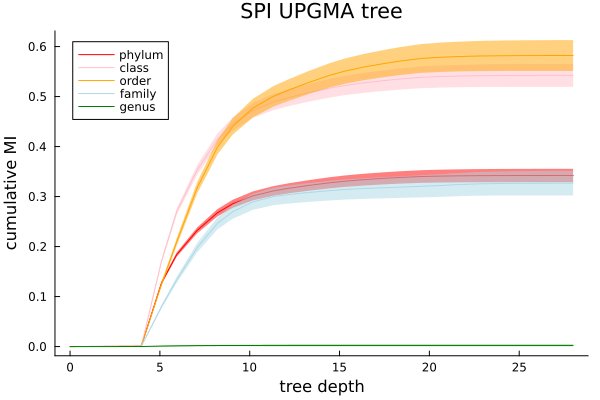

In [54]:
minmax = extrema(mapinternalnodes(network_distance, spi_upgma_tree_50pct, spi_upgma_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)
# pltdf = filter(:taxaID => !=("random"), spi_upgma_MIdf)
pltdf = filter(:taxaID => x-> !∈(String(x), ["kingdom", "random", "species"]), spi_upgma_MIdf)
plot(
    cuts,
    cumsum(reshape(pltdf.MI_boot_mean, 100, 5), dims=1),
    ribbon=cumsum(2 * reshape(pltdf.MI_boot_std, 100, 5), dims=1),
    title="SPI UPGMA tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

In [42]:
savefig(joinpath(pdir, "CumulativeMI_SPI_UPGMA_tree.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/banfieldtree_analysis_mark2/CumulativeMI_SPI_UPGMA_tree.pdf"

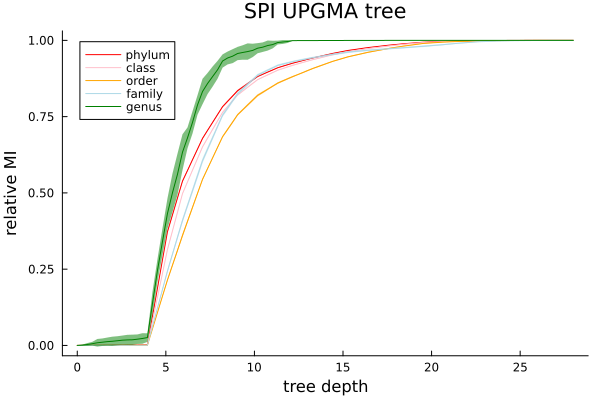

In [56]:
minmax = extrema(mapinternalnodes(network_distance, spi_upgma_tree_50pct, spi_upgma_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

# pltdf = filter(:taxaID => !=("random"), boot_SPIupgma_pltdf)
pltdf = filter(:taxaID => x-> !∈(String(x), ["kingdom", "random", "species"]), boot_SPIupgma_pltdf)

plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 5),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 5),
    title="SPI UPGMA tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [57]:
savefig(joinpath(pdir, "RelativeMI_SPI_UPGMA_tree.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/banfieldtree_analysis_mark2/RelativeMI_SPI_UPGMA_tree.pdf"

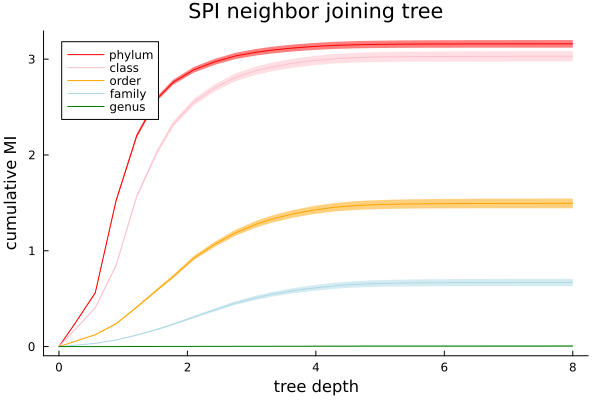

In [58]:
minmax = extrema(mapinternalnodes(network_distance, spi_nj_tree_50pct, spi_nj_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)
# pltdf = filter(:taxaID=>!=("random"), spi_nj_MIdf)
pltdf = filter(:taxaID => x-> !∈(String(x), ["kingdom", "random", "species"]), spi_nj_MIdf)

plot(
    cuts,
    cumsum(reshape(pltdf.MI_boot_mean, 100, 5), dims=1),
    ribbon=cumsum(2 * reshape(pltdf.MI_boot_std, 100, 5), dims=1),
    title="SPI neighbor joining tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

In [59]:
savefig(joinpath(pdir, "CumulativeMI_SPI_NJ_tree.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/banfieldtree_analysis_mark2/CumulativeMI_SPI_NJ_tree.pdf"

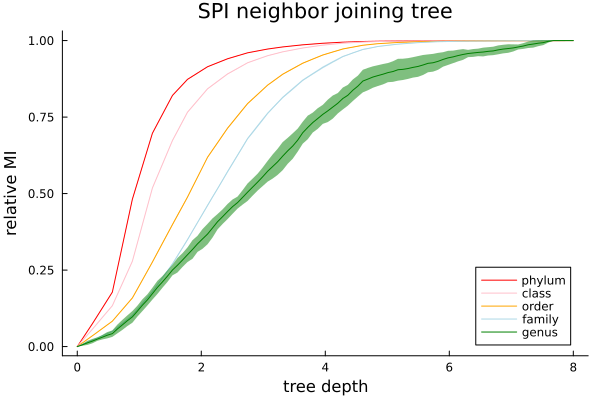

In [60]:
minmax = extrema(mapinternalnodes(network_distance, spi_nj_tree_50pct, spi_nj_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

# pltdf = filter(:taxaID => !=("random"), boot_SPInj_pltdf)
pltdf = filter(:taxaID => x-> !∈(String(x), ["kingdom", "random", "species"]), boot_SPInj_pltdf)

plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 5),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 5),
    title="SPI neighbor joining tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [61]:
savefig(joinpath(pdir, "RelativeMI_SPI_NJ_tree.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/banfieldtree_analysis_mark2/RelativeMI_SPI_NJ_tree.pdf"

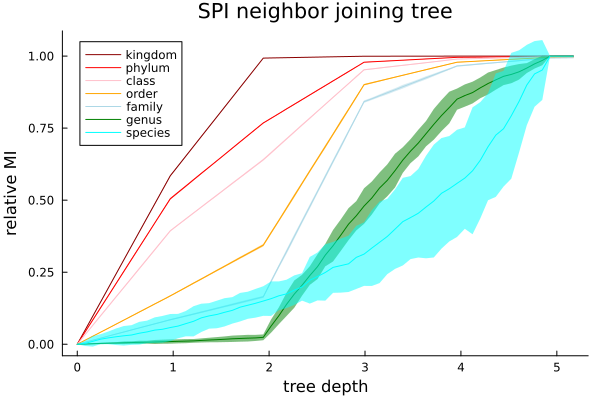

In [ ]:
minmax = extrema(mapinternalnodes(network_distance, spi_nj_tree_50pct, spi_nj_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plottingrange = 1:65

pltdf = filter(:taxaID => !=("random"), boot_SPInj_pltdf)
plot(
    cuts[plottingrange],
    reshape(pltdf.cumulative_boot_mean, 100, 7)[plottingrange, :],
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7)[plottingrange, :],
    title="SPI neighbor joining tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [ ]:
savefig(joinpath(pdir, "RelativeMI_SPI_NJ_tree_zoomedintreedepth_treedepth1-65pct.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/banfieldtree_analysis/RelativeMI_SPI_NJ_tree_zoomedintreedepth_treedepth1-65pct.pdf"

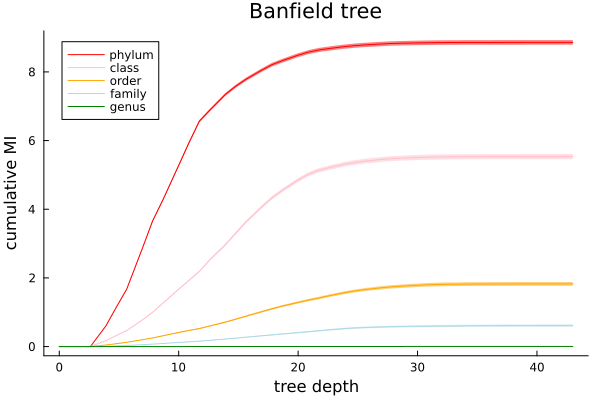

In [63]:
minmax = extrema(mapinternalnodes(network_distance, banfieldtree_50pct, banfieldtree_50pct))
cuts = range(0, minmax[2], length=NCUTS)
# pltdf = filter(:taxaID=>!=("random"), banfield_MIdf)
pltdf = filter(:taxaID => x-> !∈(String(x), ["kingdom", "random", "species"]), banfield_MIdf)

plot(
    cuts,
    cumsum(reshape(pltdf.MI_boot_mean, 100, 5), dims=1),
    ribbon=cumsum(2 * reshape(pltdf.MI_boot_std, 100, 5), dims=1),
    title="Banfield tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

In [ ]:
savefig(joinpath(pdir, "CumulativeMI_Banfield_tree.pdf"))

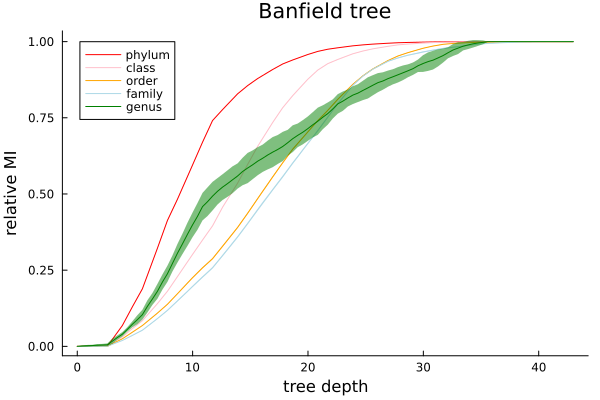

In [64]:
minmax = extrema(mapinternalnodes(network_distance, banfieldtree_50pct, banfieldtree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

# pltdf = filter(:taxaID => !=("random"), boot_banfield_pltdf)
pltdf = filter(:taxaID => x-> !∈(String(x), ["kingdom", "random", "species"]), boot_banfield_pltdf)
plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 5),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 5),
    title="Banfield tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [65]:
savefig(joinpath(pdir, "RelativeMI_Banfield_tree.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/banfieldtree_analysis_mark2/RelativeMI_Banfield_tree.pdf"

In [ ]:
plot(spi_nj_tree_50pct)

## Plot 7 levels of taxonomy curves

In [106]:
NCUTS = 100

taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus" "species"]
taxarankcolors = [:darkred :red :pink :orange :lightblue :green :aqua];
# taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus"  "random"]
# taxarankcolors = [:darkred :red :pink :orange :lightblue :green  :grey];

1×7 Matrix{Symbol}:
 :darkred  :red  :pink  :orange  :lightblue  :green  :aqua

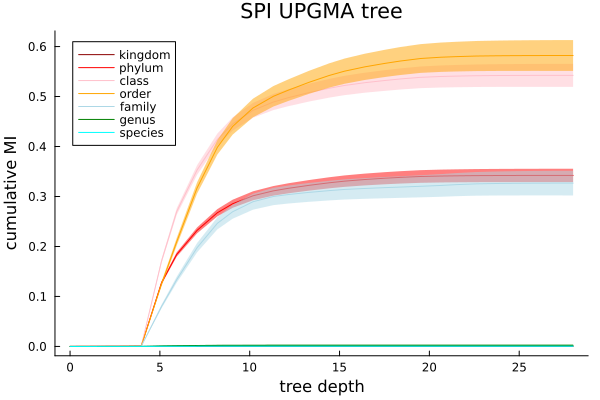

In [92]:
minmax = extrema(mapinternalnodes(network_distance, spi_upgma_tree_50pct, spi_upgma_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)
pltdf = filter(:taxaID=>!=("random"), spi_upgma_MIdf)
plot(
    cuts,
    cumsum(reshape(pltdf.MI_boot_mean, 100, 7), dims=1),
    ribbon=cumsum(2 * reshape(pltdf.MI_boot_std, 100, 7), dims=1),
    title="SPI UPGMA tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

In [ ]:
savefig(joinpath(pdir, "CumulativeMI_SPI_UPGMA_tree.pdf"))

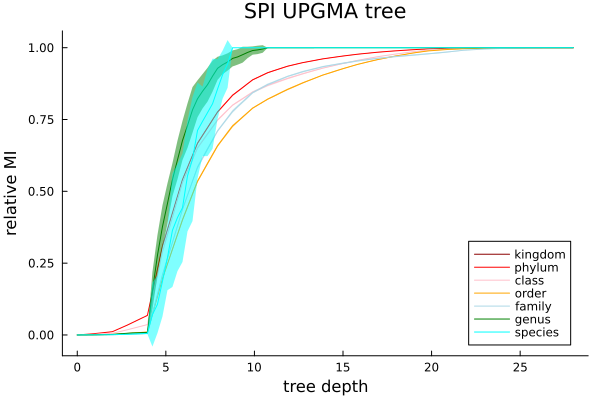

In [93]:
minmax = extrema(mapinternalnodes(network_distance, spi_upgma_tree_50pct, spi_upgma_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

pltdf = filter(:taxaID => !=("random"), boot_SPIupgma_pltdf)
plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 7),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7),
    title="SPI UPGMA tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [ ]:
savefig(joinpath(pdir, "RelativeMI_SPI_UPGMA_tree.pdf"))

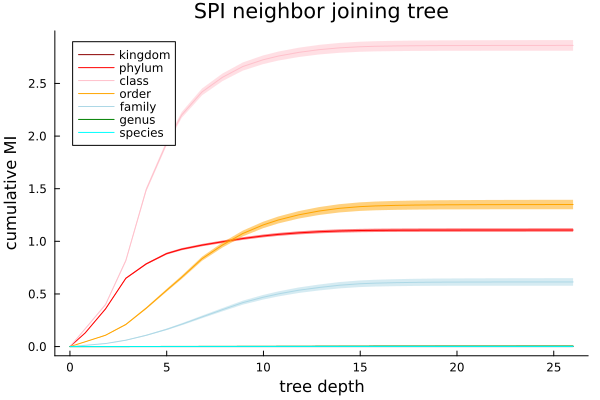

In [126]:
minmax = extrema(mapinternalnodes(network_distance, spi_nj_tree_50pct, spi_nj_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)
pltdf = filter(:taxaID=>!=("random"), spi_nj_MIdf)
plot(
    cuts,
    cumsum(reshape(pltdf.MI_boot_mean, 100, 7), dims=1),
    ribbon=cumsum(2 * reshape(pltdf.MI_boot_std, 100, 7), dims=1),
    title="SPI neighbor joining tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

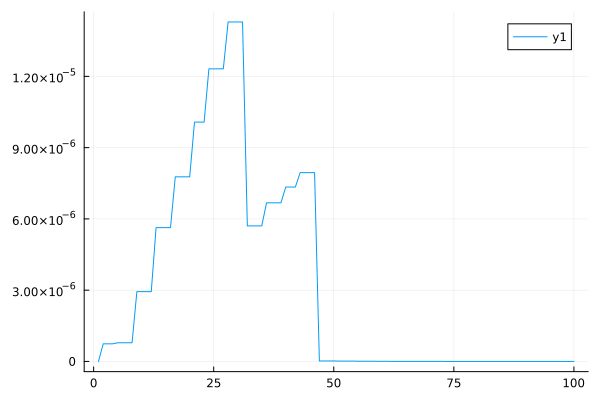

In [173]:
filter(:taxaID => ==("species"), spi_nj_MIdf) |>
    df -> @df df plot(:MI)

In [ ]:
savefig(joinpath(pdir, "CumulativeMI_SPI_NJ_tree.pdf"))

In [161]:
p = Int.(I(2117)[triu(trues(2117, 2117), 1)]);
p1 = copy(p)
p1[1:3] .= 1

3-element view(::Vector{Int64}, 1:3) with eltype Int64:
 1
 1
 1

In [157]:
(rowmeta.species .== permutedims(rowmeta.species))[triu(trues(2117, 2117), 1)] |> sum

3

In [169]:
rand([1,0],size(p1))

2239786-element Vector{Int64}:
 1
 0
 0
 0
 1
 1
 1
 1
 1
 1
 ⋮
 0
 0
 1
 0
 0
 1
 0
 1
 0

In [171]:
empiricalMI(rand([1,0],size(p1)), p1)

7.610051688811126e-8

In [134]:
2117 / length(unique(rowmeta.species))

1.0014191106906338

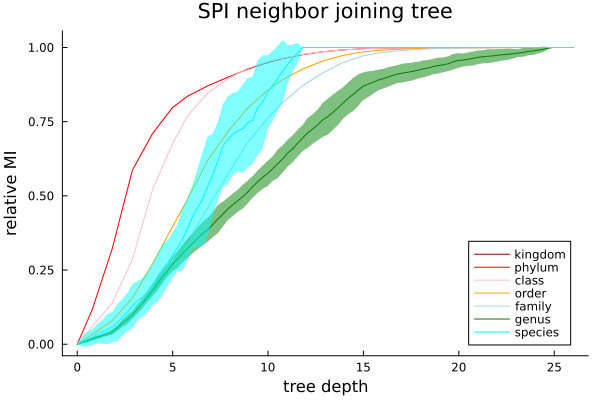

In [127]:
minmax = extrema(mapinternalnodes(network_distance, spi_nj_tree_50pct, spi_nj_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

pltdf = filter(:taxaID => !=("random"), boot_SPInj_pltdf)
plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 7),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7),
    title="SPI neighbor joining tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [ ]:
savefig(joinpath(pdir, "RelativeMI_SPI_NJ_tree.pdf"))

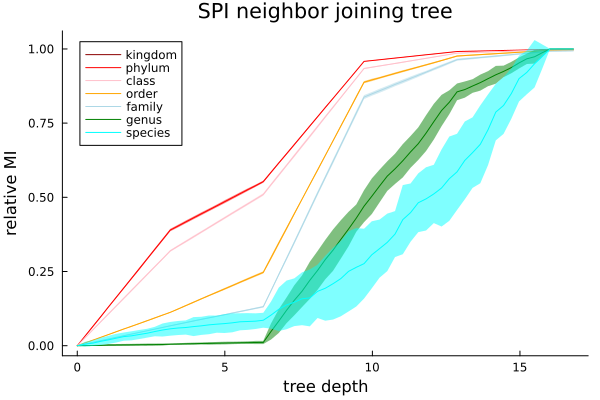

In [108]:
minmax = extrema(mapinternalnodes(network_distance, spi_nj_tree_50pct, spi_nj_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plottingrange = 1:65

pltdf = filter(:taxaID => !=("random"), boot_SPInj_pltdf)
plot(
    cuts[plottingrange],
    reshape(pltdf.cumulative_boot_mean, 100, 7)[plottingrange, :],
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7)[plottingrange, :],
    title="SPI neighbor joining tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [ ]:
savefig(joinpath(pdir, "RelativeMI_SPI_NJ_tree_zoomedintreedepth_treedepth1-65pct.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/banfieldtree_analysis/RelativeMI_SPI_NJ_tree_zoomedintreedepth_treedepth1-65pct.pdf"

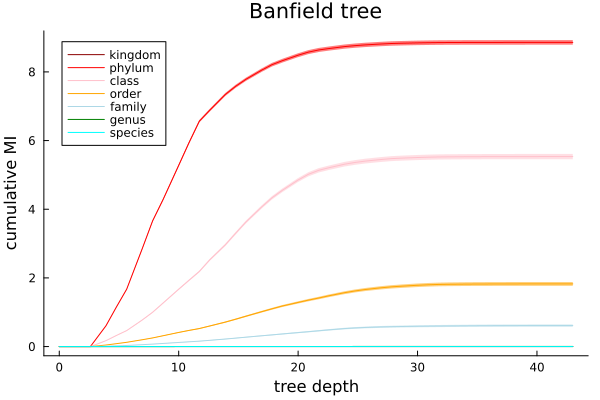

In [87]:
minmax = extrema(mapinternalnodes(network_distance, banfieldtree_50pct, banfieldtree_50pct))
cuts = range(0, minmax[2], length=NCUTS)
pltdf = filter(:taxaID=>!=("random"), banfield_MIdf)
plot(
    cuts,
    cumsum(reshape(pltdf.MI_boot_mean, 100, 7), dims=1),
    ribbon=cumsum(2 * reshape(pltdf.MI_boot_std, 100, 7), dims=1),
    title="Banfield tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

In [ ]:
savefig(joinpath(pdir, "CumulativeMI_Banfield_tree.pdf"))

In [90]:
pltdf

Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,kingdom,NaN,NaN
2,kingdom,NaN,NaN
3,kingdom,NaN,NaN
4,kingdom,NaN,NaN
5,kingdom,NaN,NaN
6,kingdom,NaN,NaN
7,kingdom,NaN,NaN
8,kingdom,NaN,NaN
9,kingdom,NaN,NaN


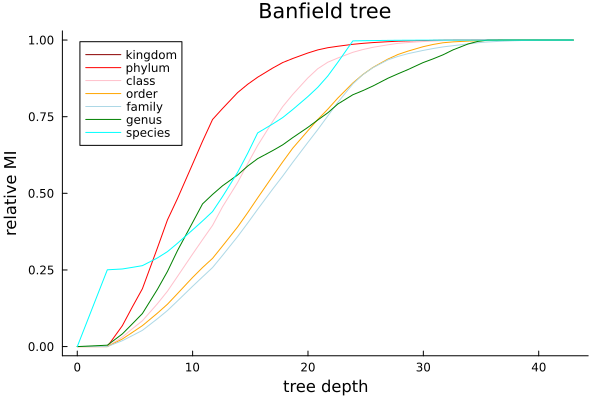

In [89]:
minmax = extrema(mapinternalnodes(network_distance, banfieldtree_50pct, banfieldtree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

pltdf = filter(:taxaID => !=("random"), boot_banfield_pltdf)
plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 7),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7),
    title="Banfield tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [ ]:
savefig(joinpath(pdir, "RelativeMI_Banfield_tree.pdf"))

In [ ]:
plot(spi_nj_tree_50pct)

# Plot full Banfield MSA

In [ ]:
heatmap(replace(permutedims(stack(adf.sequence)), '-' => NaN), yflip = true, framestyle=:none, colorbar=:none, ratio=1)

In [ ]:
savefig(joinpath(pdir, "banfield_msa.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/banfieldtree_analysis/banfield_msa.pdf"

In [ ]:
taxonomylevels = ["kingdom", "phylum", "class", "order", "family", "genus", "species"]
lineageroworder = indexin(adf.label, lineagedf.ORGANISM)
rowmeta = lineagedf[lineageroworder, taxonomylevels]
rowmeta[!, "random"] .= sample(["0", "1"], nrow(rowmeta))
IDS = lineagedf.ORGANISM[lineageroworder]
for col in eachcol(rowmeta)
    replace!(col, missing=>"")
end
havelabels = vec(mapslices(r->all(r .!= ""), Matrix(rowmeta), dims=2));

In [ ]:
first(adf[havelabels,:], 5).sequence |>
    stack |>
    x -> getindex(permutedims(x), 1:5, 1:5) |>
    x -> mapslices(join, x, dims=2)

5×1 Matrix{String}:
 "MFKK-"
 "-MLKK"
 "MAIHS"
 "MAIHA"
 "MPLNS"

In [ ]:
first(adf[havelabels,:], 5).sequence |>
    stack |>
    x -> getindex(permutedims(x), 1:5, lastindex(x,1)-10:lastindex(x,1)) |>
    x -> mapslices(join, x, dims=2)

5×1 Matrix{String}:
 "FKSH--P-VKK"
 "-----------"
 "FKAH-GG-MTR"
 "FKAH-GG-MTR"
 "FKSH--QPGKK"

In [ ]:
first(rowmeta[havelabels,:], 5)

Row,kingdom,phylum,class,order,family,genus,species,random
,String15?,String31?,String31?,String?,String?,String?,String,String
1,Bacteria,Chlamydiae,Chlamydiia,Chlamydiales,Chlamydiaceae,Chlamydia,Chlamydia pneumoniae,1
2,Bacteria,Chlamydiae,Chlamydiia,Parachlamydiales,Waddliaceae,Waddlia,Waddlia chondrophila,1
3,Bacteria,Verrucomicrobia,Opitutae,Opitutales,Opitutaceae,Opitutus,Opitutus terrae,1
4,Bacteria,Verrucomicrobia,Opitutae,Opitutales,Opitutaceae,Geminisphaera,Geminisphaera colitermitum,0
5,Bacteria,Verrucomicrobia,Opitutae,Puniceicoccales,Puniceicoccaceae,Coraliomargarita,Coraliomargarita akajimensis,1
